offset time =  1.637891156462585  offset position = 72231  sensor distance = 545.4177551020408  run time =  0.14513134956359863


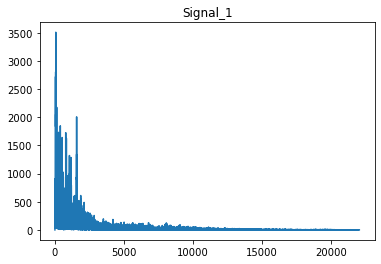

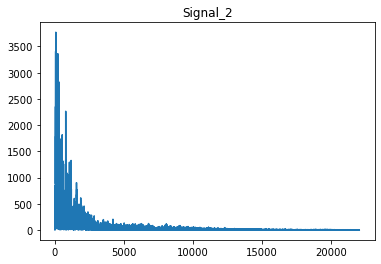

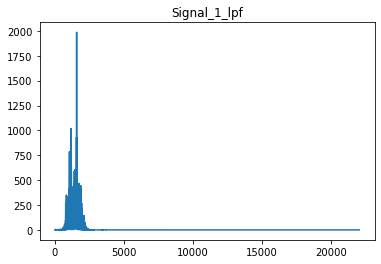

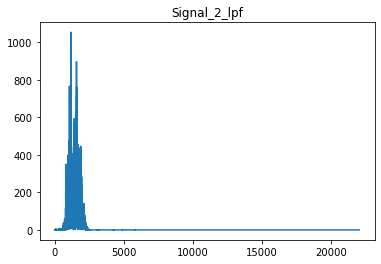

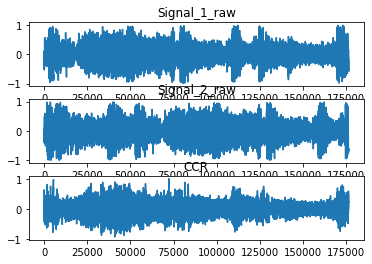

In [13]:
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import islice
from scipy import signal


# Use bandpass filter to remove singal noise, and show improvement on spatial cross corellation?
# function to read lines from file to list
def read_file( fileName ):
    """
    Read input data file and filters for numerical values 
 
    Inputs:
    ----------------
        fileName   File path 
 
    Output:
    ----------------
        data_list  List of read of only numerical data values

    References:
        super9super9 bronze badges, et al. 
        “Read File from Line 2 or Skip Header Row.” 
        Stack Overflow, 1 May 1960, stackoverflow.com/questions/4796764/read-file-from-line-2-or-skip-header-row.    
    """  
    data = open( fileName ,"r") 
    result = [float(line.strip()) for line in islice(data, 1, None)] 
    data.close()

    return result

def mean_dif(pattern):
    """
    Find find shift for 1D 
 
    Inputs:
    ----------------
        pattern   Pattern must be non empty 

    
    Output:
    ----------------
        norm_scores  Normed cross correlation array
     """      

    pattern = pattern - np.mean(pattern)

    return pattern



def arr_fft(pattern):
    """
    FFT of the input array
 
    Inputs:
    ----------------
        pattern   1D array
        
    Output:
    ----------------
        fft   FFT of array

     """
    #Take FFt along columns, then rows       
    fft = np.fft.fft(pattern)

    return fft


def arr_ifft(pattern):
    """
    IFFT of the input array
 
    Inputs:
    ----------------
        pattern   1D array
        
    Output:
    ----------------
        ifft   FFT of array

     """
    #Take FFt along columns, then rows       
    ifft = np.fft.ifft(pattern)

    return ifft



def arr_complex_conj(pattern):
    """
    Complex of the input array
 
    Inputs:
    ----------------
        pattern   1D array
        
    Output:
    ----------------
        pattern_fft_conj   Complex conjugate of array

     """  

    pattern_fft_conj = np.conj(pattern)

    return pattern_fft_conj 


def corr(pattern,template):
    """
    Correlation of 1D arrays using FFT
 
    Inputs:
    ----------------
        pattern   1D array

        template    1D search array 
        
    Output:
    ----------------
        corr   Correlation array

     """  

    fft_1 = arr_fft(pattern)
    fft_2 = arr_fft(template)
    fft_2_conj = arr_complex_conj(pattern)

    corr = arr_ifft(fft_2_conj * fft_1)
    corr /= np.max(corr)
    #print(np.linalg.norm(np.imag(corr)))
    corr = np.real(corr)

    # np.real_if_close(corr)

    #real=np.isreal(corr)              #Boolean condition for real part
    #real_array=corr[real]             #Storing it in variable using boolean indexing
    #real_array = np.real_if_close(corr)

    return corr


def remove_repeated(pattern,len, Fs, label):
    """
    Using Hermiticty of FT of real array, cut off mirrored frequencies and 
 
    Inputs:
    ----------------
        pattern   1D array

        len    size of array

        Fs  Sampling frequency

        label   Singal label
        
    Output:
    ----------------
        freq    FT without repeat conjugate pair   

     """  
    pattern = arr_fft(pattern)
    N = int(len / 2)
    f_res = Fs / len
    P = np.abs(pattern[:N])
    freq = np.arange(0, Fs / 2 - f_res, f_res)

    plt.figure()
    plt.plot(freq, P)
    plt.title(label)
    plt.show()

    return freq



def low_pass(pattern, Fs, len, label, freq ):
    """
    Apply low pass filter to remove low frequency noise 
 
    Inputs:
    ----------------
        pattern   1D array

        len    size of array

        Fs  Sampling frequency

        label   Singal label

        freq    Half of signal FT
        
    Output:
    ----------------
        Plot of single sided signal   

     """   
    N = int(len / 2)
    b = signal.firwin(150, [1000, 2000], fs = Fs, pass_zero=False)
    y = signal.lfilter(b, 1, pattern)
    Y = arr_fft(y)
    Pf = np.abs(Y[:N])
    plt.figure()
    plt.plot(freq, Pf)
    plt.title(label)
    plt.show()

     
def main():

    

    data_1 = np.array(read_file( "sensor1Data.txt")) 
    data_2 = np.array(read_file( "sensor2Data.txt"))
   

    data_1_shift = mean_dif(data_1)
    data_2_shift = mean_dif(data_2)

    len_1 = len(data_1_shift)
    len_2 = len(data_2_shift)

    # print(len_1, len_2)

    #Store signal information
    Fs = 44100 #Sampling frequency
    T_s = 1 / Fs 
    speed_m_sec = 333

    start = time.time()
    corr_sig_1_2 = corr( data_1_shift, data_2_shift)

    #Find offset
    offset = np.argmax(corr_sig_1_2)
    offset_sec = offset * T_s
    sensor_distance = offset_sec * speed_m_sec

    end = time.time()
                
    print("offset time = ", offset_sec, " offset position =", offset, " sensor distance =", sensor_distance, " run time = ", end - start )

    # print(fft_1, '\n')
    # print(corr, '\n')
    # print(offset, '\n')

    #remove mirrored frequency data
    fft_half_1 = remove_repeated(data_1_shift,len_1, Fs, "Signal_1")
    fft_half_2 = remove_repeated(data_2_shift,len_2, Fs, "Signal_2")

    # LPF
    low_pass(data_1_shift, Fs, len_1, "Signal_1_lpf", fft_half_1 )
    low_pass(data_2_shift, Fs, len_2, "Signal_2_lpf", fft_half_2 )


    #plotting
    plt.figure()
    plt.subplot(311)  
    plt.plot(data_1)
    plt.title("Signal_1_raw")

    plt.subplot(312)  
    plt.plot(data_2)
    plt.title("Signal_2_raw")

    plt.subplot(313)  
    plt.plot(corr_sig_1_2)
    plt.title("CCR")
    plt.show()   

if __name__ == '__main__':
    
    main()